In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate

# 分析重建方法

一个未知衰减系数为 $\mu(x,y)$的物体可以在多个位置进行扫描。在扫描过程中，光子穿过物体，所产生的强度被扫描仪拾取。已知

$$I = I_0 e^{-\int \mu(x,y)ds}$$

其中，$ds$ 是穿过物体的特定直线。如果写成

$$\ln(I_0/I) = \int \mu(x,y)ds$$ 

左边的量可以在不同的扫描仪位置下测量。上图所示是两个可能的扫描仪位置及相应的 $\ln(I_0/I)$ 值。

接下来我们将把 

* $\mu(x,y)=f(x,y)$ 
* $\ln(I_0/I)=p(r,\theta)$.

参数如下

* 参数 $\theta$ 是扫描仪的倾斜度（即扫描仪 1 的倾斜度为 $\theta=90^{\circ}$，扫描仪 2 的倾斜度为 $\theta=-45^{\circ}）$。
* 参数 $r$ 指定扫描仪上的水平位置（即扫描仪 1 在 $r=0$ 时测量最大值，并随着 $r\to \pm$ 衰减）。

目标是在给定 $p(r,\theta)$的情况下重建 $f(x,y)$

我们将从 $f(x,y)$开始，利用它得到 $p(r,\theta)$，然后研究从 $p(r,\theta)$重新获得 $f(x,y)$ 的技术。

In [2]:
#image = shepp_logan_phantom()
image = np.ones([100,100])
# Resize Image
diag = len(np.diag(image)//2)
image = np.pad(image, pad_width=diag+10)

定义与正方形坐标值相对应的 $x$ 和 $y$ 网格。$x=0$和$y=0$对应旋转点

In [3]:
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)
image[(xv-0.1)**2+(yv-0.2)**2<0.01] = 2

# Create a rotated image
image_rot = rotate(image, 45)

绘制正方形及其旋转图

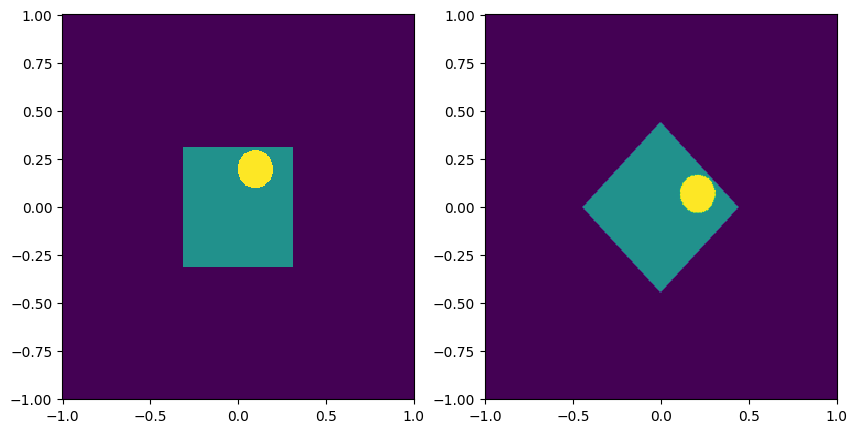

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pcolor(xv,yv,image, shading='auto')
ax[1].pcolor(xv,yv,image_rot, shading='auto')
plt.show()

旋转的正方形可以让我们得到各种不同的 $\theta$ 的 $p(r,\theta)$。让我们为各种不同的 $\theta$ 创建一系列不同的旋转方向

In [5]:
thetas = np.arange(0,180,5) * np.pi/180
rs = _
dtheta = np.diff(thetas)[0]
dr = np.diff(rs)[0]
rotations = np.array([rotate(image, theta*180/np.pi) for theta in thetas])

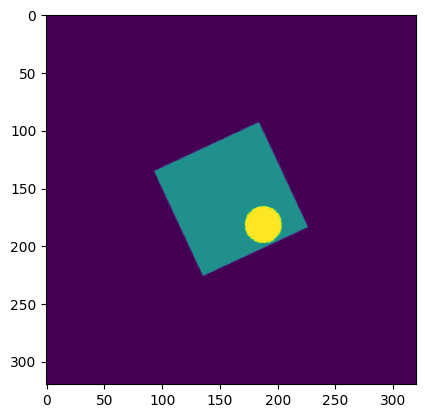

In [6]:
plt.imshow(rotations[5])

定义 $p(r,\theta)$：正弦曲线。这涉及到对每一个 $\theta$ 的值，对每一个围绕纵轴旋转的图像求和（这样就得到了每一个图像的分布 $g(r)$）（这样就得到了一个净函数 $p(r,\theta)$)

In [7]:
p = np.array([rotation.sum(axis=0)*dr for rotation in rotations]).T

绘制给定角度的扫描图

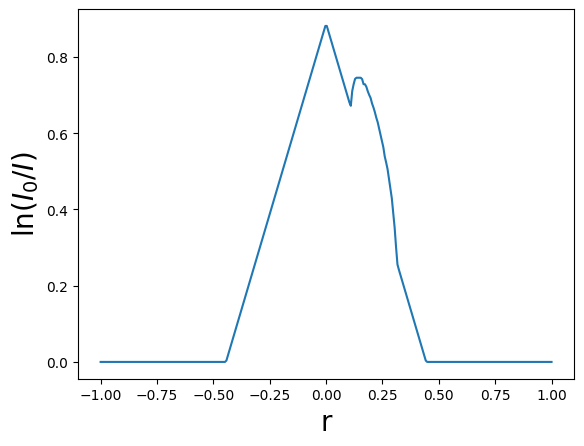

In [8]:
plt.plot(rs, p[:,9])
plt.xlabel('r', fontsize=20)
plt.ylabel('$\ln(I_0/I)$', fontsize=20)
plt.show()

绘制正弦曲线

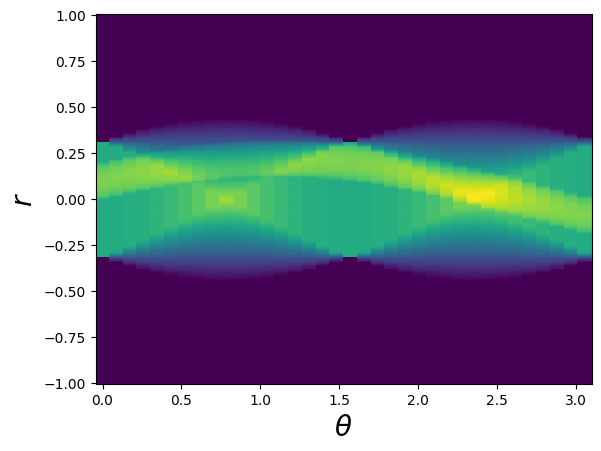

In [9]:
plt.pcolor(thetas, rs, p, shading='auto')
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel('$r$', fontsize=20)
plt.show()

# 正常背面投影：

对于角度为 $\theta$ 的扫描，点 $(x,y)$ 所贡献的 $r$ 值为 $x\cos\theta + y\sin\theta$ 。

$$f_{\text{BP}}(x,y) = \int_{0}^{pi} p(x\cos\theta+y\sin\theta, \theta)d\theta \approx \sum_i p(x\cos\theta_i+y\sin\theta_i, \theta_i) \Delta \theta_i$$

对上述正弦曲线进行插值的函数

In [10]:
p_interp = RectBivariateSpline(rs, thetas, p)

定义 $f_{\text{BP}}$

In [11]:
def get_fBP(x,y):
    return p_interp(x*np.cos(thetas)+y*np.sin(thetas), thetas, grid=False).sum() * dtheta

fBP = np.vectorize(get_fBP)(xv,yv)

绘制反投影图像

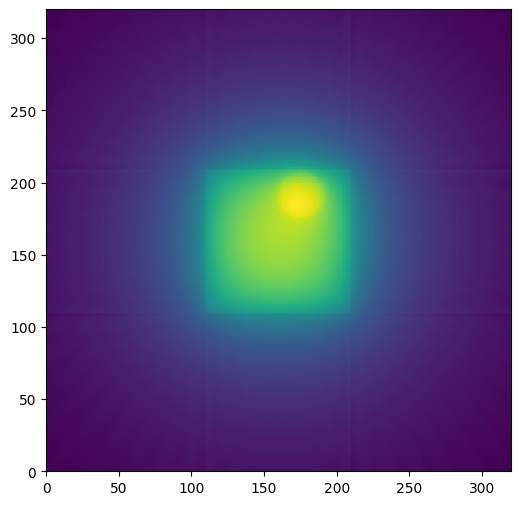

In [12]:
plt.figure(figsize=(6,6))
plt.pcolor(fBP)
plt.show()

# 滤波后投影

这利用了傅立叶域信息

* $f(x,y)$ 具有二维傅立叶变换 $$F(\nu_x, \nu_y) =\iint dx dy f(x,y)e^{j2\pi \nu_x x}e^{j2\pi \nu_y y}$$。
* $p(r,\theta)$ 具有一维傅立叶变换 $$P(\nu, \theta) = \int p(r,\theta)e^{j2\pi \nu r} dr$$

由此可知

$$F(\nu\cos\theta,\nu\sin\theta) =\iint dxdy f(x,y) e^{j2\pi x \nu\cos\theta}e^{j2\pi y \nu\sin\theta}$$

让 $r=x\cos\theta+y\sin\theta$.这就是直线的方程（当改变 $r$ 时平行于扫描方向移动）。同时让 $t=-x\cos\theta+y\sin\theta$ 成为一条与之垂直的直线（改变 $t$ 时垂直于扫描仪方向移动）。那么

$$F(\nu\cos\theta, \nu\sin\theta) =\iint drdt f(x,y) e^{j2\pi r \nu} = \int dr \left[ \int f(x,y) dt \right] e^{j2\pi r \nu} = \int dr p(r,\theta)e^{j2\pi r \nu} = P(\nu,\theta) $$

换句话说，$f(x,y)$ 的二维傅里叶变换与氡函数$p(r,\theta)$ 的一维傅里叶变换有关

$$boxed{F(\nu\cos\theta, \nu\sin\theta) = P(\nu,\theta)}$$

因此，给定变换，我们可以在傅里叶空间进行滤波，然后进行二维逆变换，得到 $f(x,y)$。利用这一点，我们可以明确求解 $f(x,y)$：


In [13]:
from scipy.fft import fft, ifft

Get stuff

In [14]:
P = fft(p, axis=0)
nu = np.fft.fftfreq(P.shape[0], d=np.diff(rs)[0])

In [15]:
P.T.shape

(36, 320)

In [16]:
nu.shape

(320,)

In [17]:
integrand = P.T * np.abs(nu)
integrand = integrand.T
p_p = np.real(ifft(integrand, axis=0))

In [18]:
p_p_interp = RectBivariateSpline(rs, thetas, p_p)

In [37]:
def get_f(x,y):
    return p_p_interp(x*np.cos(thetas)+y*np.sin(thetas), thetas, grid=False).sum() * dtheta

f = np.vectorize(get_f)(xv,yv)

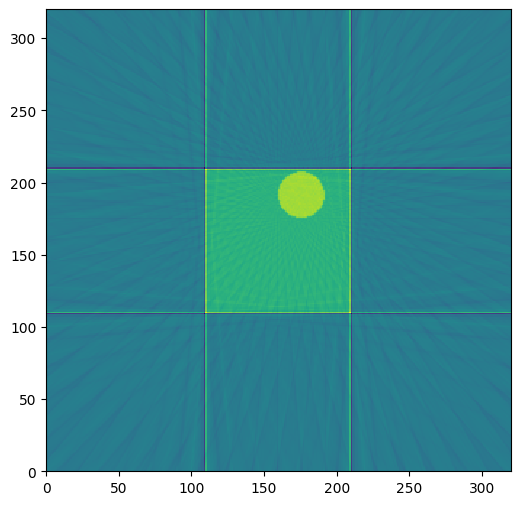

In [38]:
plt.figure(figsize=(6,6))
# f[f<0] = 0
# f[f>2] = 2
plt.pcolor(f, shading='auto')
# plt.colorbar()
plt.show()

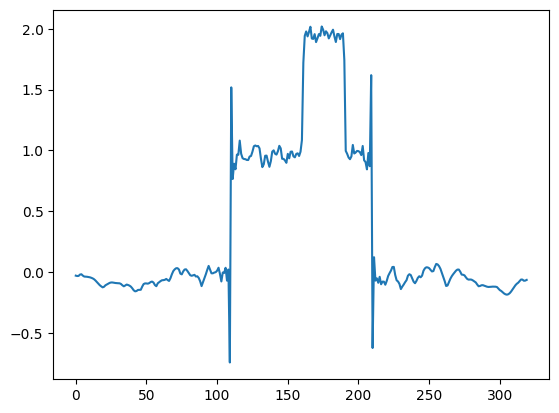

In [42]:
plt.plot(f[185])

# 使用 SkImage 图库

In [22]:
from skimage.transform import radon, iradon

In [23]:
theta = np.arange(0., 180., .5)
sinogram = radon(image, theta=theta)

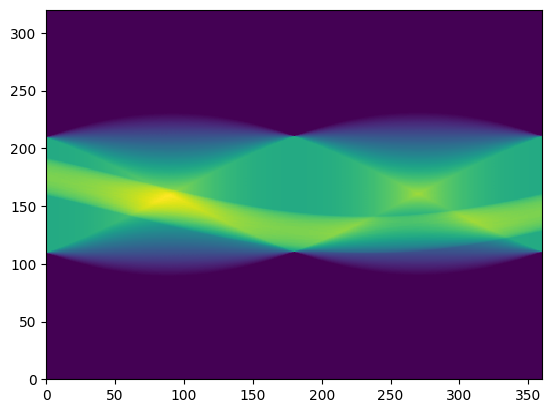

In [24]:
plt.pcolor(sinogram)

In [25]:
reconstruction_img = iradon(sinogram, theta=theta, filter_name='ramp')

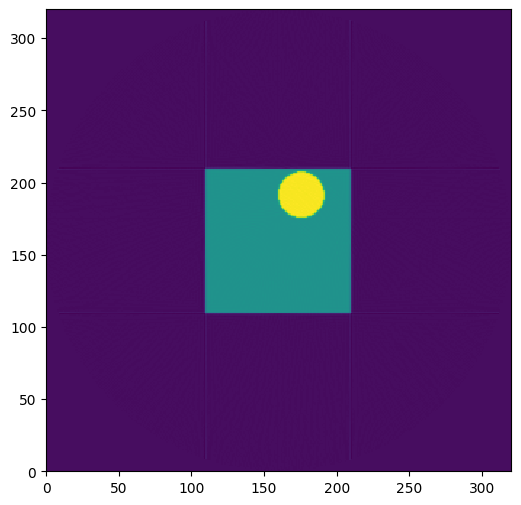

In [26]:
plt.figure(figsize=(6,6))
plt.pcolor(reconstruction_img);

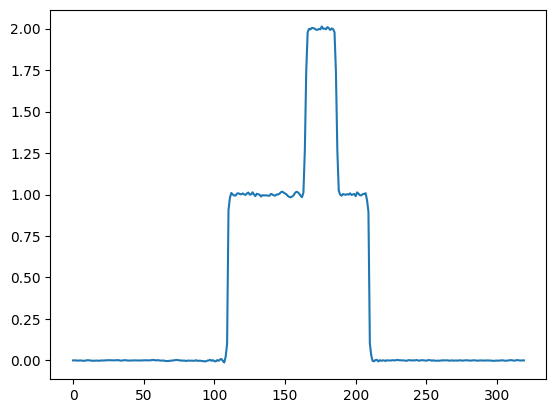

In [27]:
plt.plot(reconstruction_img[180]);